In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [26]:
# Load the training and test datasets
training_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
training_target = training_df['SalePrice']
training_df.drop('SalePrice', axis=1, inplace=True)
test_ids = test_df['Id']

Pre-process your data, explain your pre-processing steps, and the reasons why you need them.
(Hint: data pre-processing steps can include but are not restricted to: dealing with missing values,
normalizing numerical values, dealing with categorical values etc.)

In [27]:
#check for missing data
from pandas.io.formats.info import DataFrameInfo
temp = pd.DataFrame(training_df)
info = DataFrameInfo(data=temp)

infodf = pd.DataFrame(
  {'Column': info.ids, 
   'Non-Null Count':info.non_null_counts, 
   'Dtype':info.dtypes})

pd.set_option('display.max_rows', None)
temp_train_info = infodf.sort_values(by=['Non-Null Count'])
missing_data_details = temp_train_info.loc[temp_train_info['Non-Null Count'] < 1460]
#print(missing_data_details.sort_values(by='Non-Null Count'))

In [28]:
#check for missing data
from pandas.io.formats.info import DataFrameInfo
temp = pd.DataFrame(test_df)
info = DataFrameInfo(data=temp)

infodf_test = pd.DataFrame(
  {'Column': info.ids, 
   'Non-Null Count':info.non_null_counts, 
   'Dtype':info.dtypes})

pd.set_option('display.max_rows', None)
temp_test_info = infodf_test.sort_values(by=['Non-Null Count'])
missing_data_details = temp_test_info.loc[temp_test_info['Non-Null Count'] < 1459]
#print(missing_data_details.sort_values(by='Non-Null Count'))

* 19 columns total have missing data. 3 are numerical (LotFrontage, GarageYrBlt, MasVnrArea); the remaining 16 are categorical.
* Pandas also treats 'None' as a missing value, this is what causes a discrepancy between MasVnrType and MasVnrArea.
* Where MasVnrType is None, MasVnrArea is 0. Actually, looking into the csv we can see there are 8 rows where both MasVnrType and MasVnrArea are both NA.
* We can replace the 'None' by 'NoMas', and for the 8 rows of NA, we can replace with NoMas and 0 respectively
* (assume that if NA, the MasVnrArea is actually zero and MasVnrType is None).

Now that missing values and categorical values are worked on, we need to normalize numerical values.

In [29]:
LotFrontage_mean = training_df['LotFrontage'].mean()
training_df['LotFrontage'].fillna(LotFrontage_mean, inplace=True)
GarageYrBlt_mean = training_df['GarageYrBlt'].mean()
training_df['GarageYrBlt'].fillna(GarageYrBlt_mean, inplace=True)

values = {'Alley': 'noal',
          'BsmtQual':'nobsmt', 'BsmtCond':'nobsmt', 'BsmtExposure':'nobsmt', 'BsmtFinType1':'nobsmt', 'BsmtFinType2':'nobsmt',
          'GarageFinish':'nogrg', 'GarageQual':'nogrg', 'GarageCond':'nogrg','GarageType':'nogrg',
          'PoolQC':'nopool','Fence':'nofence','MiscFeature':'nomscft','FireplaceQu':'nofrplc'}
training_df.fillna(value=values, inplace=True)

training_df['MasVnrArea'].fillna(0, inplace=True)
training_df['MasVnrType'].fillna("NoMas", inplace=True)

Electrical_mode = training_df['Electrical'].mode()
training_df['Electrical'].fillna('SBrkr', inplace=True)

# Normalize numeric feature values
numeric_continuous_columns_list = list(training_df.select_dtypes(include='number').columns)

cols_to_remove_from_numeric_list = ['MSSubClass']
for col in cols_to_remove_from_numeric_list:
    numeric_continuous_columns_list.remove(col)
    
for column in numeric_continuous_columns_list:
    training_df[column] = (training_df[column] - training_df[column].min()) / (training_df[column].max() - training_df[column].min())

#pd.set_option('display.max_rows', None)

In [30]:
#training_df.describe()

In [31]:
#training_df.info()

In [32]:
LotFrontage_mean = test_df['LotFrontage'].mean()
test_df['LotFrontage'].fillna(LotFrontage_mean, inplace=True)
GarageYrBlt_mean = test_df['GarageYrBlt'].mean()
test_df['GarageYrBlt'].fillna(GarageYrBlt_mean, inplace=True)

values = {'Alley': 'noal',
          'BsmtQual':'nobsmt', 'BsmtCond':'nobsmt', 'BsmtExposure':'nobsmt', 'BsmtFinType1':'nobsmt', 'BsmtFinType2':'nobsmt',
          'GarageFinish':'nogrg', 'GarageQual':'nogrg', 'GarageCond':'nogrg','GarageType':'nogrg',
          'PoolQC':'nopool','Fence':'nofence','MiscFeature':'nomscft','FireplaceQu':'nofrplc'}
test_df.fillna(value=values, inplace=True)

test_df['MasVnrArea'].fillna(0, inplace=True)
test_df['MasVnrType'].fillna("NoMas", inplace=True)

Electrical_mode = training_df['Electrical'].mode()
test_df['Electrical'].fillna('SBrkr', inplace=True)

# Normalize numeric feature values    
for column in numeric_continuous_columns_list:
    test_df[column] = (test_df[column] - test_df[column].min()) / (test_df[column].max() - test_df[column].min())

In [33]:
#test_df.describe()

In [34]:
#test_df.info()

In [35]:
#perform one hot encoding for categorical variables
one_hot_columns_list = list(training_df.columns)

for col in numeric_continuous_columns_list:
    one_hot_columns_list.remove(col)

# exclude variables we do not want to use in the OLS regression
for col in (['HouseStyle','BldgType','BsmtFinType1','BsmtFinType2','BsmtCond','Condition2','BsmtExposure',
             'MiscFeature','GarageFinish','GarageQual','Exterior2nd','SaleType','SaleCondition','MSSubClass','MasVnrType','PoolQC',
            'KitchenQual','Fence','Foundation','RoofStyle','RoofMatl','Exterior1st','ExterCond','ExterQual',
            'PavedDrive','Alley','Street','MSZoning','Electrical']):
    one_hot_columns_list.remove(col)
#print(one_hot_columns_list)

one_hot_encoded_data = pd.get_dummies(training_df[one_hot_columns_list],columns = one_hot_columns_list).astype(int)
one_hot_encoded_columns_list = list(one_hot_encoded_data.columns)
#print(one_hot_encoded_columns_list)

numeric_columns_to_ignore = ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','GarageYrBlt','YearRemodAdd','MoSold','BedroomAbvGr','KitchenAbvGr',
                             'LowQualFinSF','1stFlrSF','2ndFlrSF','MiscVal','GarageCars','WoodDeckSF','YrSold','MasVnrArea','OpenPorchSF',
                             'EnclosedPorch','3SsnPorch','ScreenPorch','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath']

for col in numeric_columns_to_ignore:
    numeric_continuous_columns_list.remove(col)
    
preprocessed_training_df = pd.concat([training_df[numeric_continuous_columns_list + cols_to_remove_from_numeric_list], one_hot_encoded_data], axis=1, join='inner')

In [36]:
#preprocessed_training_df.info()
#pd.set_option('display.max_rows', 15)

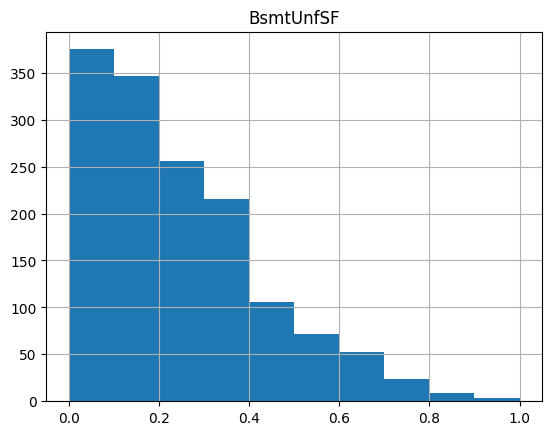

In [37]:
# Lot Area Histogram
bsmtunfsf_histogram = training_df.hist(column="BsmtUnfSF")

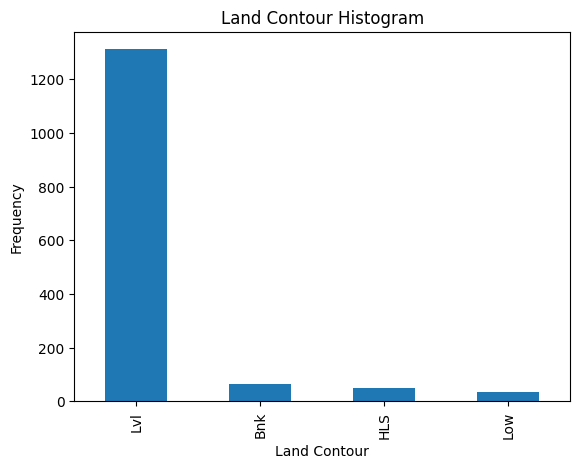

In [38]:
# Land Contour Histogram

import matplotlib.pyplot as plt
training_df['LandContour'].value_counts().plot(kind='bar')
plt.title('Land Contour Histogram')
plt.xlabel('Land Contour')
plt.ylabel('Frequency')
plt.show()

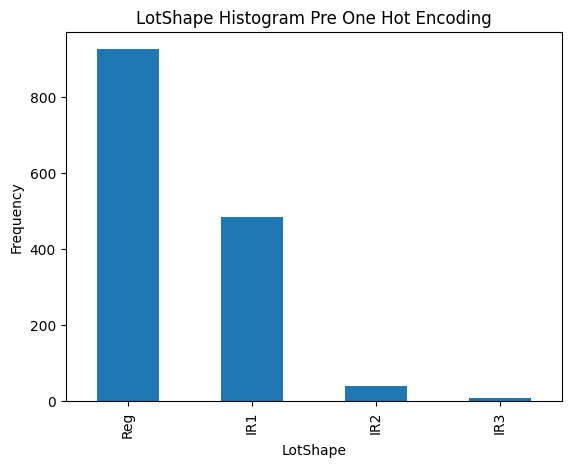

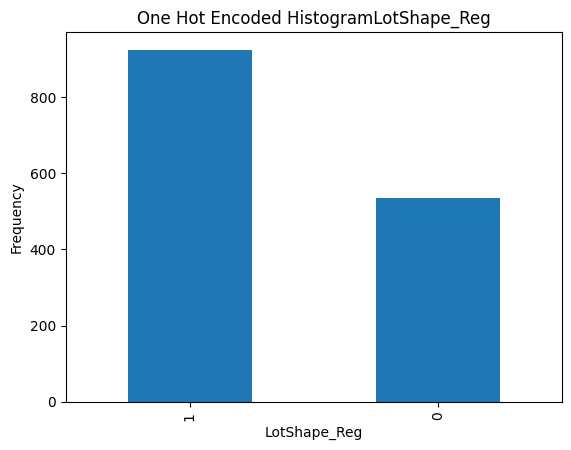

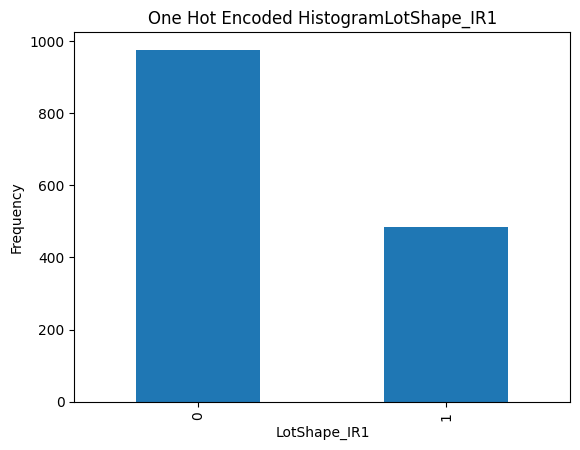

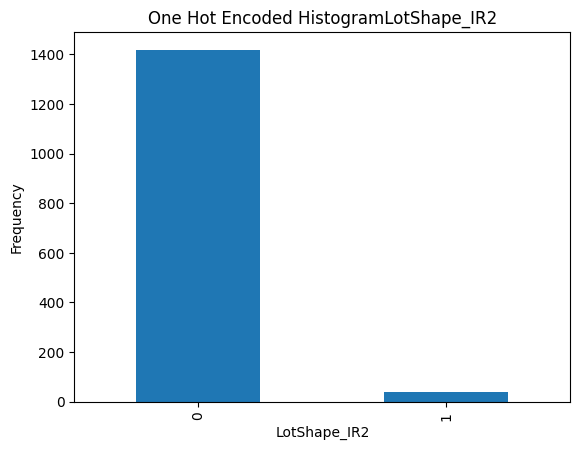

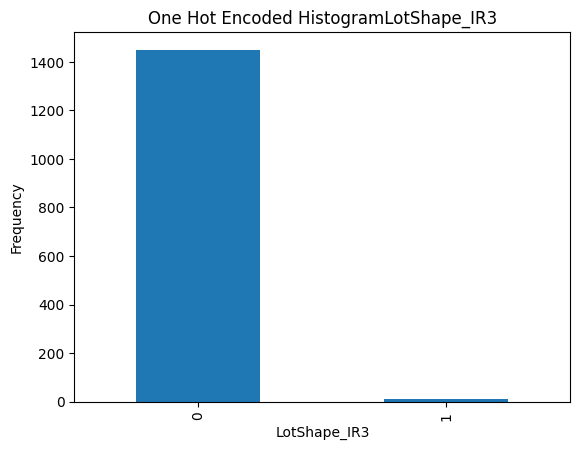

In [39]:
training_df['LotShape'].value_counts().plot(kind='bar')
plt.title('LotShape Histogram Pre One Hot Encoding')
plt.xlabel('LotShape')
plt.ylabel('Frequency')
plt.show()

lotshapes = ['LotShape_Reg', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3']

for col in lotshapes:
    preprocessed_training_df[col].value_counts().plot(kind='bar')
    plt.title('One Hot Encoded Histogram' + col)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()  

In [40]:
one_hot_encoded_data = pd.get_dummies(test_df[one_hot_columns_list],columns = one_hot_columns_list).astype(int)    
preprocessed_test_df = pd.concat([test_df[numeric_continuous_columns_list + cols_to_remove_from_numeric_list], one_hot_encoded_data], axis=1, join='inner')

In [41]:
preprocessed_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 106 entries, Id to GarageCond_nogrg
dtypes: float64(12), int64(94)
memory usage: 1.2 MB


In [42]:
list1 = list(preprocessed_training_df.columns)
list2 = list(preprocessed_test_df.columns)
 
# prints the missing and additional elements in list2
print("Missing values in second list: \n", (set(list1).difference(list2)))
print("\n Additional values in second list:\n", (set(list2).difference(list1)))
 
# prints the missing and additional elements in list1
print("\n Missing values in first list:\n", (set(list2).difference(list1)))
print("\n Additional values in first list:\n", (set(list1).difference(list2)))

diff_list_1_set = set(list1).difference(list2)
diff_list_2_set = set(list2).difference(list1)

Missing values in second list: 
 {'Heating_Floor', 'Utilities_NoSeWa', 'Heating_OthW'}

 Additional values in second list:
 set()

 Missing values in first list:
 set()

 Additional values in first list:
 {'Heating_Floor', 'Utilities_NoSeWa', 'Heating_OthW'}


In [43]:
diff_list_1=[]
diff_list_2=[]

for col in diff_list_1_set:
    diff_list_1.append(col)
for col in diff_list_2_set:
    diff_list_2.append(col)

for col in diff_list_1:
    #print(col)
    preprocessed_training_df.drop(col, axis=1, inplace=True)
    
for col in diff_list_2:
    #print(col)
    preprocessed_test_df.drop(col,axis=1,inplace=True)

In [44]:
preprocessed_training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 106 entries, Id to GarageCond_nogrg
dtypes: float64(12), int64(94)
memory usage: 1.2 MB


In [45]:
preprocessed_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 106 entries, Id to GarageCond_nogrg
dtypes: float64(12), int64(94)
memory usage: 1.2 MB


In [46]:
#let us split the dataset into design matrix X_train and target vector y_train
y_train = training_target/100000;
X_train = preprocessed_training_df;
X_train.drop("Id",axis=1,inplace=True)
preprocessed_test_df.drop("Id",axis=1,inplace=True)

In [47]:
# manually drop at least one of each set of dummy variables (from the same feature)

list_of_dummies_to_drop = ['FireplaceQu_nofrplc',
              'BsmtQual_nobsmt', 
              'GarageCond_nogrg','GarageType_nogrg',  
              'LotShape_Reg','LandContour_Lvl','Utilities_AllPub',
              'LotConfig_Inside','LandSlope_Gtl','Neighborhood_Blmngtn','Condition1_Norm',
              'Heating_GasA','HeatingQC_TA','CentralAir_N',
              'Functional_Typ',]
              #'BsmtCond_TA','BsmtExposure_Av','BsmtFinType1_ALQ','BsmtFinType2_ALQ','BsmtQual_TA', 
              #'GarageCond_TA', 'GarageFinish_Fin', 'GarageQual_TA', 'GarageType_Attchd', 'Exterior2nd_Other',
              #'BsmtFinType1_nobsmt','BsmtFinType2_nobsmt','MiscFeature_nomscft', 'GarageFinish_nogrg','GarageQual_nogrg', 'BsmtExposure_nobsmt'
              # 'SaleType_New','SaleCondition_Normal','BsmtCond_nobsmt','Condition2_Norm','MSSubClass_20','MasVnrType_NoMas','PoolQC_nopool',
                #'KitchenQual_TA','Fence_nofence','Foundation_PConc','RoofStyle_Flat','RoofMatl_CompShg','Exterior1st_AsbShng',
              #'ExterCond_TA','ExterQual_TA','PavedDrive_N','Alley_noal','Street_Grvl','MSZoning_FV','Electrical_SBrkr'
X_train.drop(list_of_dummies_to_drop,axis=1, inplace=True)

In [48]:
preprocessed_test_df.drop(list_of_dummies_to_drop, axis=1, inplace=True)

In [49]:
print(y_train.mean())

1.8092119589041096


In [50]:
#implementing OLS to calculate optimal parameters
theta_best = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
theta_best_df = pd.DataFrame(data=theta_best[np.newaxis, :], columns=X_train.columns)
theta_best_df

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,TotalBsmtSF,GrLivArea,TotRmsAbvGrd,Fireplaces,GarageArea,...,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA
0,25.529687,4.86596,8.861619,4.559532,-3.827408,-8.711165,-15.291188,5.221231,-0.389525,1.339939,...,-1.950609,-1.298339,-1.353234,-2.864302,-1.647943,0.032721,3.063153,3.414869,1.853766,1.938717


In [51]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print("Trained theta best df: \n", theta_best_df)

# generate predictions and calculate errors
y_train_pred = X_train.dot(theta_best)
residuals_training = y_train - y_train_pred
residuals_squared = np.power(residuals_training,2)
y_train_mean = y_train.mean()
y_distance_from_mean = y_train - y_train_mean
y_distance_from_mean_squared = np.power(y_distance_from_mean,2)
r2 = 1-(residuals_squared.sum()/y_distance_from_mean_squared.sum())

print("Y train pred mean: ", y_train_pred.mean())
print("Residuals training mean: ", residuals_training.mean())
print("Residuals squared mean: ", residuals_squared.mean())
print("Y distance from mean mean: ", y_distance_from_mean.mean())
print("Y distance from mean squared mean: ",y_distance_from_mean_squared.mean())
print("R2: ", r2)

Trained theta best df: 
    LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  TotalBsmtSF  \
0    25.529687  4.86596     8.861619     4.559532  -3.827408    -8.711165   

   GrLivArea  TotRmsAbvGrd  Fireplaces  GarageArea  PoolArea  MSSubClass  \
0 -15.291188      5.221231   -0.389525    1.339939 -0.543722    0.012873   

   LotShape_IR1  LotShape_IR2  LotShape_IR3  LandContour_Bnk  LandContour_HLS  \
0      0.182054      0.829888      -2.29481        -0.671865         0.740138   

   LandContour_Low  LotConfig_Corner  LotConfig_CulDSac  LotConfig_FR2  \
0         0.348478         -1.029045           0.319734       -0.24036   

   LotConfig_FR3  LandSlope_Mod  LandSlope_Sev  Neighborhood_Blueste  \
0      -2.254708       0.298042      -0.410254             -4.540874   

   Neighborhood_BrDale  Neighborhood_BrkSide  Neighborhood_ClearCr  \
0            -7.104192             -7.238436             -6.312134   

   Neighborhood_CollgCr  Neighborhood_Crawfor  Neighborhood_Edwards  

Interpretation of the MSE and R2

In [52]:
# generate predictions on the new patients
y_test_pred = preprocessed_test_df.dot(theta_best)
y_test_pred = y_test_pred * 100000
print("Y test pred mean: ", y_test_pred.mean())

y_test_pred_df = pd.DataFrame(y_test_pred.astype(float), columns = ['SalePrice'])
y_test_pred_df.fillna(0,inplace=True)
submission_list = pd.concat([test_ids, y_test_pred_df], axis=1, join='inner')

Y test pred mean:  408156.37166384695


In [53]:
#submission_list.describe()
submission_list.head()

,Id,SalePrice
0,1461,637004.012009
1,1462,501357.400875
2,1463,283866.753135
3,1464,600796.186503
4,1465,261501.220193


In [54]:
#print(submission_list)

In [55]:
submission_list.to_csv('/kaggle/working/housing_predictions_for_submission', index=False)